In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import find_peaks

In [3]:
def zscore_2d(matrix):
    matrix_mean = matrix.mean(1, keepdims=True)
    matrix_std = matrix.std(1, keepdims=True)
    return (matrix - matrix_mean) / matrix_std

In [4]:
def get_freq(sampling_rate, level):
    freqs = []
    freq_top = sampling_rate * 0.5
    for i in range(1, level+1):
        start, end = freq_top * 0.5, freq_top
        freqs.append((start, end))
        freq_top = start
    freqs.append((0, freq_top))
    return freqs[::-1]

In [5]:
def load_RealData():
    traindata_path = '../../Data/RealData/all_back_train.npy'
    testdata_path = '../../Data/RealData/all_back_test.npy'

    train_data, test_data = np.load(traindata_path), np.load(testdata_path)
    signals_train, labels_train = train_data[:, :1000], train_data[:, 1000:]
    signals_test, labels_test = test_data[:, :1000], test_data[:, 1000:]

    print(signals_train.shape, labels_test.shape)

    return labels_train, labels_test, zscore_2d(signals_train), zscore_2d(signals_test)

In [7]:
def wavelet_denoise_select(signals, level, wavelet, sampling_rate, show=False):
    filtered_signals = []
    for signal in signals:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dep_freqs = get_freq(sampling_rate, level)

        coeffs_filtered = [np.zeros_like(coeffs[0])] + coeffs[1:5] + [np.zeros_like(c) for c in coeffs[5:]]
        reconstructed_signal = pywt.waverec(coeffs_filtered, wavelet)
        if show:
            print(dep_freqs[1:5])
            plt.figure(figsize=(12, 5))
            plt.plot(signal, label='Noisy Signal')
            plt.plot(reconstructed_signal, label='Filtered Signal')
            plt.legend()
            plt.show()
            break

        filtered_signals.append(reconstructed_signal)
        # break
    return np.array(filtered_signals)

In [8]:
def check_uncertain(signal, window, threshold_uncertain=0.2):
    end = len(signal)
    pieces_indexes = [(start, min(start + window, end)) for start in range(0, end, window)]
    pieced_signals = [signal[begin: over] for begin, over in pieces_indexes]

    def cal_energy(piece):
        return np.sum(np.square(piece))

    pieced_energy = [cal_energy(pieced_signal) for pieced_signal in pieced_signals]

    delta_pieced_energy = np.abs(np.diff(pieced_energy)) / pieced_energy[:-1]
    # delta_pieced_energy = np.array(pieced_energy[1:]) / pieced_energy[:-1]

    if np.sum(delta_pieced_energy <= threshold_uncertain) == len(delta_pieced_energy):
        # 全部符合标准，说明并没有不确定性
        uncertain = 0
    else:
        uncertain = 1

    return uncertain

# for idx in range(0, 300):
#     signal = filtered_signals[idx]
#     delta_energy = check_uncertain(signal, 200)
#
#     zero_crossings = np.where(np.diff(np.sign(signal)))[0]
#     zero_crossings_rate = len(zero_crossings) / (len(signal)-1)
#
#     # print(np.sum(delta_energy <= 0.2))
#     if (np.sum(delta_energy <= 0.2) == len(delta_energy)) and zero_crossings_rate < 0.13:
#         print(delta_energy)
#         print(zero_crossings_rate)
#         plt.figure()
#         plt.plot(filtered_signals[idx])
#         plt.show()

def zcr_and_status(signals, threshold=0.13):
    zcrs, status = [], []

    for cnt, signal in enumerate(signals):
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        zero_crossings_rate = len(zero_crossings) / (len(signal)-1)
        zcrs.append(zero_crossings_rate)

        # 确定是否是uncertain的状态
        uncertain_bool = check_uncertain(signal, window=200)
        if uncertain_bool:
            status.append(-1)
        else:
            if zero_crossings_rate > threshold:
                status.append(0)
            else:
                status.append(1)

    return np.array(zcrs), np.array(status)

In [9]:
def re_status(signals, initial_statuses):
    """I don't need to implement it now."""
    return initial_statuses

def get_good_signals(signals, statuses, zcrs):
    good_signals_idx = []
    for cnt, (status, zcr) in enumerate(zip(statuses, zcrs)):
        if status == 1 and zcr < 0.125:
            good_signals_idx.append(cnt)
    # print(good_signals_idx)
    return signals[good_signals_idx], np.array(good_signals_idx)

In [10]:
# acf
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    acf = np.correlate(signal - mean, signal - mean, mode='full') / (np.var(signal) * n)
    return acf[n-1:]

def get_acfs(envelopes):
    acfs = []
    for env in envelopes:
        acf = autocorrelation(env)
        acfs.append(acf)
    return np.array(acfs)

In [11]:
def segmentation_nk2(signals, envelopes, labels, alpha, resample_rate):

    show = False
    all_pieces = []
    for cnt in range(len(signals)):

        envelope = envelopes[cnt]
        hr = labels[cnt, 2]
        signal = signals[cnt]
        peaks_temp, _ = find_peaks(envelope, height=np.max(envelope) * 0.15, distance=(int(5500*resample_rate) // hr))
        peaks_dis_mean = np.int(np.mean(np.diff(peaks_temp)))

        peaks, _ = find_peaks(envelope, height=np.max(envelope) * alpha, distance=(int(5000*resample_rate) // hr))

        if show:
            plt.figure(figsize=(12, 3))
            plt.plot(envelope)
            plt.plot(signal)
            plt.scatter(peaks ,envelope[peaks])
            plt.show()

        # epoch_start, epoch_end = int(0.45 * peaks_dis_mean), int(0.5 * peaks_dis_mean)
        epoch_start, epoch_end = int(0.65 * peaks_dis_mean), int(0.65 * peaks_dis_mean)

        pieces = []
        # print(len(peaks))
        # plt.figure(figsize=(12, 5))
        for i in range(len(peaks)):
            if peaks[i] - epoch_start < 0:
                continue
            if peaks[i] + epoch_end > int(1000*resample_rate):
                break

            start = peaks[i] - epoch_start
            end = peaks[i] + epoch_end
            # print(end-start, start, end)
            piece = signal[start: end]
            # print(len(piece))
            pieces.append(piece)
            # plt.plot(piece)
        # plt.show()
        all_pieces.append(pieces)

        if show:
            plt.figure(figsize=(12, 3))
            for line, piece in enumerate(pieces):
                plt.plot(piece, label=str(line))
            plt.legend()
            plt.show()
    return all_pieces

In [12]:
# # energy
def cal_energy(signals, window=32):
    show = False
    energies = []
    for cnt in range(len(signals)):
        signal = signals[cnt]

        signal_padded = np.pad(signal, [window//2, window//2], 'constant', constant_values=(0, 0))

        squared_signal = np.square(signal_padded)

        start = 0
        end = 0
        signal_energy = []
        for i in range(len(signal_padded)-window):
            start = i
            end = i + window
            signal_energy.append(np.sum(squared_signal[start:end]) / window)

        energies.append(np.array(signal_energy))
        if show:
            plt.figure(figsize=(12, 3))
            plt.plot(signal)
            plt.plot(signal_energy)
            plt.show()
    return energies

In [13]:
def find_last_zero_position(arr):
    zero_indices = np.where(arr == 0)[0]

    for zero_pos in zero_indices:
        if zero_pos <= 3:
            continue
        if arr[zero_pos-3] == 0 and arr[zero_pos-2] == 0 and arr[zero_pos-1] == 0 and arr[zero_pos+1] != 0:
            return zero_pos
    if len(zero_indices) > 0:
        return zero_indices[-1]
    else:
        return -1

def re_align(all_pieces):
    realigned_all_pieces = []
    for cnt, pieces in enumerate(all_pieces):
        padded_pieces = []
        for piece in pieces:
            padded_pieces.append(np.pad(piece, (35, 35), 'constant'))

        padded_pieces = np.array(padded_pieces)

        for i in range(len(padded_pieces)):
            time_series2 = padded_pieces[i]
            ccf_results = 0

            for j in range(len(padded_pieces)):
                if i == j:
                    continue
                time_series1 = padded_pieces[j]
                ccf_result = np.correlate(time_series1 - np.mean(time_series1), time_series2 - np.mean(time_series2), mode='full') / (np.std(time_series1) * np.std(time_series2) * len(time_series1))
                ccf_results += ccf_result

            lags = np.arange(-len(time_series1) + 1, len(time_series2))
            max_correlation_index = np.argmax(ccf_results)
            optimal_lag = lags[max_correlation_index]

            if optimal_lag > 30:
                optimal_lag = 30
            elif optimal_lag < -30:
                optimal_lag = -30
            new_time_series2 = np.roll(time_series2, optimal_lag)
            padded_pieces[i] = new_time_series2


        zero_start_max, zero_end_max = 0, 0
        for piece in padded_pieces:
            zero_start = find_last_zero_position(piece)
            zero_end = find_last_zero_position(piece[::-1])

            zero_start_max = max(zero_start, zero_start_max)
            zero_end_max = max(zero_end, zero_end_max)
        realigned_all_pieces.append(np.array(padded_pieces)[:, zero_start_max:-zero_end_max])

    return realigned_all_pieces

In [15]:
from scipy.signal import resample_poly

labels_train, labels_test, signals_train, signals_test = load_RealData()
wavelet = 'db12'
level = 6
sampling_rate = 100

filtered_signals = wavelet_denoise_select(signals_train, level, wavelet, sampling_rate)

print(filtered_signals.shape)
zcrs, statuses = zcr_and_status(filtered_signals)

final_statuses = re_status(filtered_signals, statuses)
good_signals, good_signals_index = get_good_signals(filtered_signals, final_statuses, zcrs)
print(good_signals.shape)
good_labels = labels_train[good_signals_index]
print(good_labels.shape)

def resample_signals(signals, resample_rate):
    resampled_signals = [resample_poly(signal, int(1000*resample_rate), 1000) for signal in signals]
    return np.array(resampled_signals)

resample_rate = 1.5
good_signals = resample_signals(good_signals, 1.5)
energies_32 = cal_energy(good_signals, window=int(48*resample_rate))

all_pieces_energy_32 = segmentation_nk2(good_signals, energies_32, good_labels, 0.5, 1.5)

realigned_all_pieces = re_align(all_pieces_energy_32)

(4672, 1000) (1655, 6)


D:\ANACONDA\envs\pytorch\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


(4672, 1000)
(270, 1000)
(270, 6)


C:\Users\86189\AppData\Local\Temp\ipykernel_15484\4264852661.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  peaks_dis_mean = np.int(np.mean(np.diff(peaks_temp)))


In [26]:
def cal_individual_energy(signal, window=32):
    signal_padded = np.pad(signal, [window//2, window//2], 'constant', constant_values=(0, 0))
    squared_signal = np.square(signal_padded)
    start = 0
    end = 0
    signal_energy = []
    for i in range(len(signal_padded)-window):
        start = i
        end = i + window
        signal_energy.append(np.sum(squared_signal[start:end]) / window)
    return np.array(signal_energy)

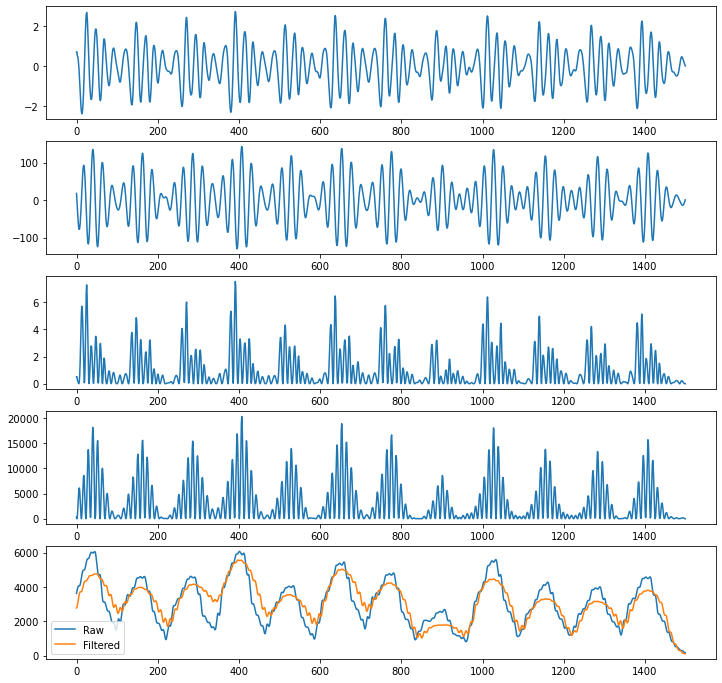

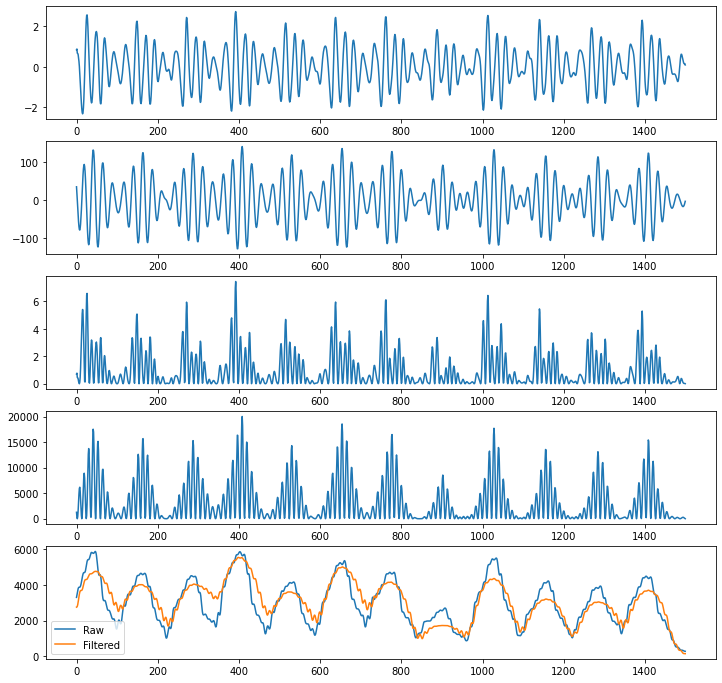

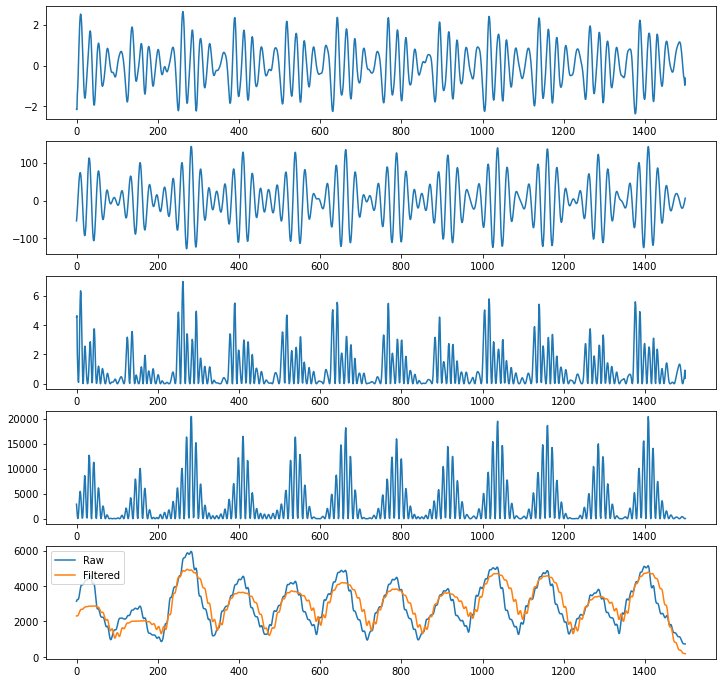

In [37]:
from tslearn.barycenters import softdtw_barycenter


for cnt, pieces in enumerate(all_pieces_energy_32):
    signal = good_signals[cnt]

    realigned_pieces = realigned_all_pieces[cnt]

    template = np.mean(realigned_pieces, axis=0)

    # plt.figure( figsize=(4, 3))
    # plt.suptitle(str(cnt))
    # for i, piece in enumerate(realigned_pieces):
    #     plt.plot(piece, alpha=0.35)
    # plt.plot(template, color='red', linewidth=2, label='Mean')
    # plt.legend()
    # plt.show()

    # plt.figure(figsize=(12, 3))
    # plt.plot(signal)
    # plt.show()

    # plt.figure(figsize=(12, 3))
    plt.subplots(5, 1, figsize=(12, 12))
    plt.subplot(511)
    plt.plot(signal)
    plt.subplot(512)
    filtered_signal = np.convolve(signal, template[::-1], mode='same')
    plt.plot(filtered_signal)
    plt.subplot(513)
    plt.plot(np.square(signal))
    plt.subplot(514)
    plt.plot(np.square(filtered_signal))
    plt.subplot(515)
    filtered_signal_envelope = cal_individual_energy(filtered_signal, window=int(64*resample_rate))
    plt.plot(energies_32[cnt] * np.mean(filtered_signal_envelope), label='Raw')
    plt.plot(filtered_signal_envelope, label='Filtered')
    plt.legend()
    plt.show()
    if cnt > 1:
        break

In [65]:
def local_max(signal, window=96):
    # signal_padded =
    signal_copied = signal.copy()
    signal_copied = np.pad(signal_copied, [0, window//2], 'constant', constant_values=0)
    # for i in range(0, len(signal_copied)-window, int(window//4)):
    for i in range(0, len(signal_copied)-window):
        start = i
        end = i + window
        pieced_signal = signal_copied[start:end]

        local_max_value = np.max(pieced_signal)
        pieced_signal[pieced_signal != local_max_value] = 0
        signal_copied[start:end] = pieced_signal

    res = signal_copied[:-window//2]
    threshold = np.max(res) * 0.05
    res[res < threshold] = 0

    return res

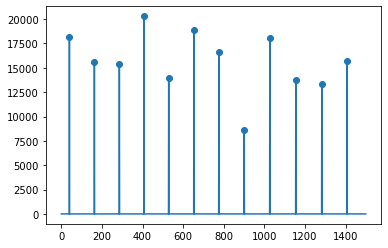

[  40  163  286  407  529  653  776  901 1027 1155 1283 1407]
[123 123 121 122 124 123 125 126 128 128 124]


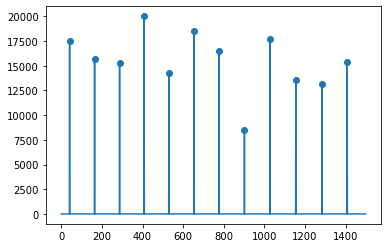

[  41  164  287  408  530  654  777  902 1028 1155 1284 1408]
[123 123 121 122 124 123 125 126 127 129 124]


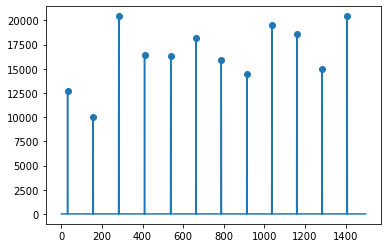

[  31  157  283  410  539  663  788  914 1037 1160 1285 1408]
[126 126 127 129 124 125 126 123 123 125 123]


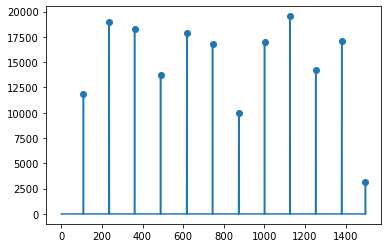

[ 109  236  361  489  618  745  874 1001 1127 1253 1381 1498]
[127 125 128 129 127 129 127 126 126 128 117]


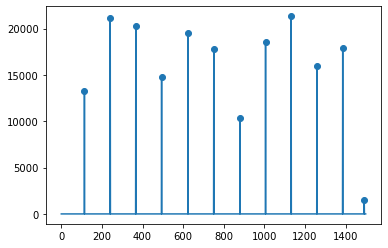

[ 114  241  367  494  624  751  880 1006 1132 1259 1386 1492]
[127 126 127 130 127 129 126 126 127 127 106]


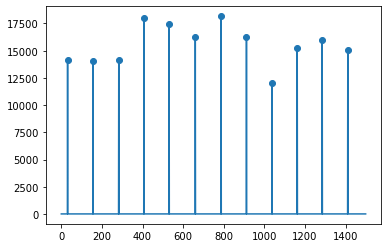

[  31  156  283  407  531  660  787  912 1038 1162 1285 1411]
[125 127 124 124 129 127 125 126 124 123 126]


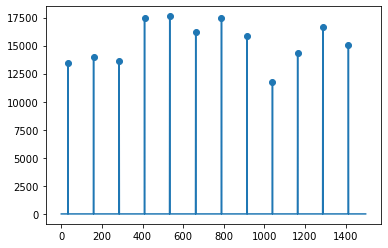

[  33  159  285  410  534  662  789  915 1040 1164 1288 1414]
[126 126 125 124 128 127 126 125 124 124 126]


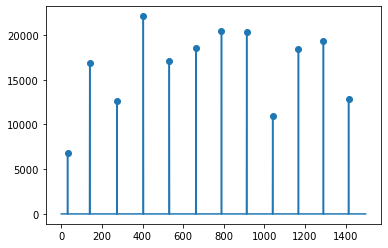

[  31  140  274  404  532  663  789  913 1041 1168 1291 1415]
[109 134 130 128 131 126 124 128 127 123 124]


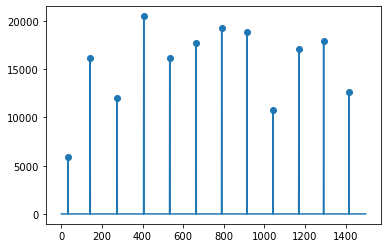

[  33  142  275  406  534  664  790  915 1043 1170 1292 1417]
[109 133 131 128 130 126 125 128 127 122 125]


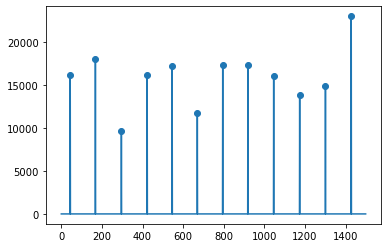

[  44  168  296  423  546  670  795  919 1046 1174 1301 1428]
[124 128 127 123 124 125 124 127 128 127 127]


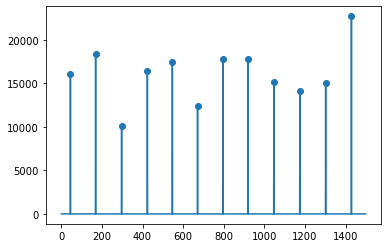

[  45  169  297  424  547  671  796  920 1047 1175 1302 1429]
[124 128 127 123 124 125 124 127 128 127 127]


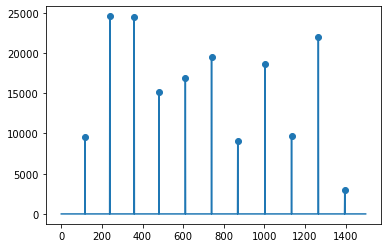

[ 117  239  359  481  611  740  869 1003 1134 1266 1396]
[122 120 122 130 129 129 134 131 132 130]


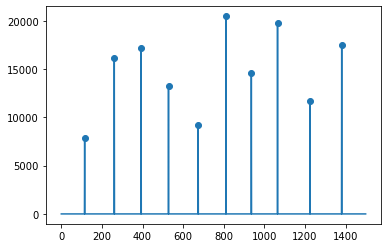

[ 115  261  393  528  674  811  936 1065 1225 1381]
[146 132 135 146 137 125 129 160 156]


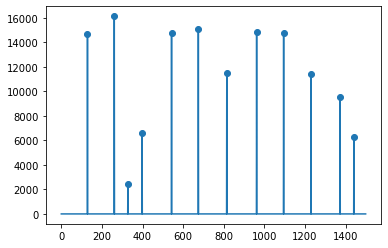

[ 129  261  328  398  543  675  815  962 1095 1230 1373 1441]
[132  67  70 145 132 140 147 133 135 143  68]


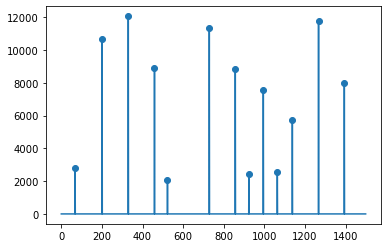

[  68  201  330  459  523  729  857  924  995 1064 1138 1267 1394]
[133 129 129  64 206 128  67  71  69  74 129 127]


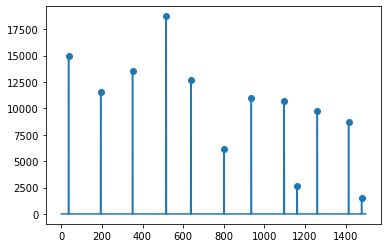

[  36  194  351  517  638  802  936 1098 1162 1261 1415 1479]
[158 157 166 121 164 134 162  64  99 154  64]


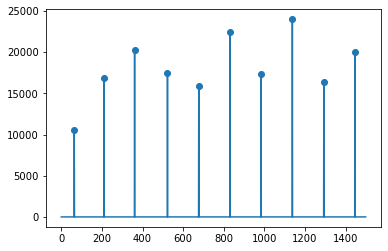

[  64  210  361  523  677  831  984 1138 1293 1446]
[146 151 162 154 154 153 154 155 153]


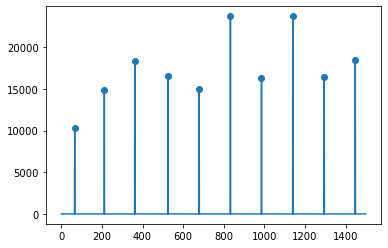

[  66  212  362  525  679  833  986 1140 1295 1448]
[146 150 163 154 154 153 154 155 153]


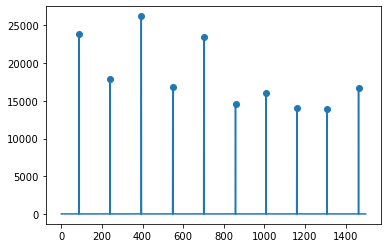

[  87  240  394  549  702  858 1008 1160 1309 1464]
[153 154 155 153 156 150 152 149 155]


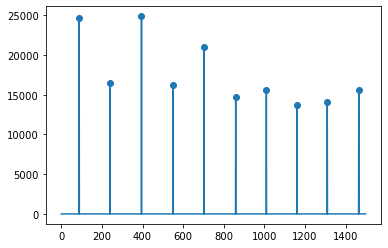

[  88  240  395  550  703  859 1010 1161 1310 1465]
[152 155 155 153 156 151 151 149 155]


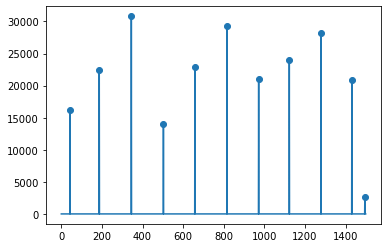

[  43  187  345  503  658  816  972 1123 1279 1431 1495]
[144 158 158 155 158 156 151 156 152  64]


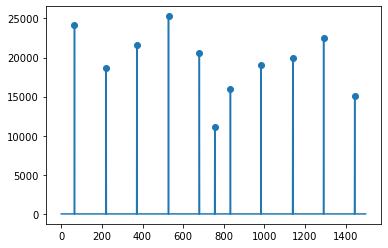

[  65  221  372  528  680  756  833  984 1140 1292 1445]
[156 151 156 152  76  77 151 156 152 153]


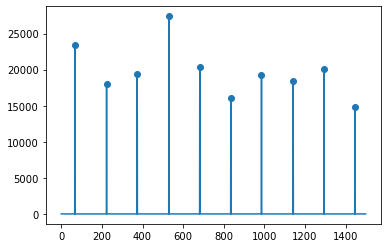

[  67  223  374  530  682  835  986 1142 1294 1446]
[156 151 156 152 153 151 156 152 152]


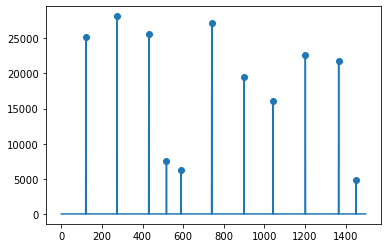

[ 121  275  431  518  590  741  900 1043 1202 1366 1452]
[154 156  87  72 151 159 143 159 164  86]


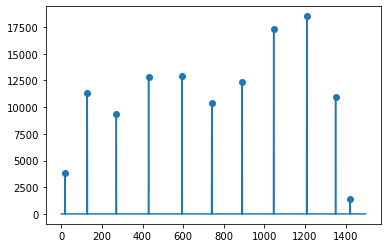

[  19  128  271  430  595  741  891 1046 1209 1351 1423]
[109 143 159 165 146 150 155 163 142  72]


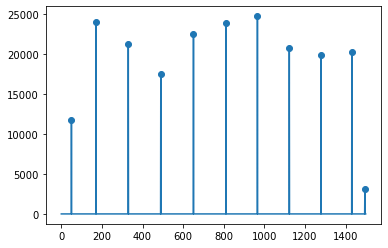

[  50  171  330  490  651  811  966 1123 1279 1431 1495]
[121 159 160 161 160 155 157 156 152  64]


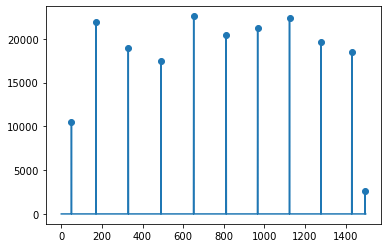

[  50  171  330  491  652  812  967 1124 1279 1431 1496]
[121 159 161 161 160 155 157 155 152  65]


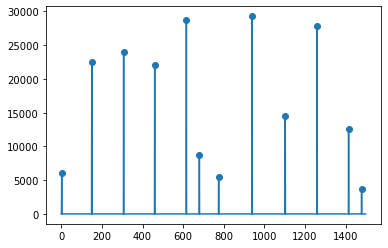

[   2  150  307  460  616  680  775  940 1103 1260 1415 1479]
[148 157 153 156  64  95 165 163 157 155  64]


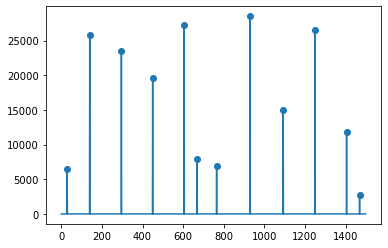

[  29  140  296  450  605  669  765  930 1093 1249 1405 1469]
[111 156 154 155  64  96 165 163 156 156  64]


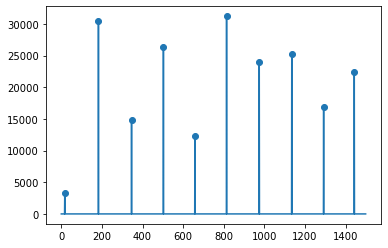

[  17  183  346  503  658  814  975 1135 1292 1443]
[166 163 157 155 156 161 160 157 151]


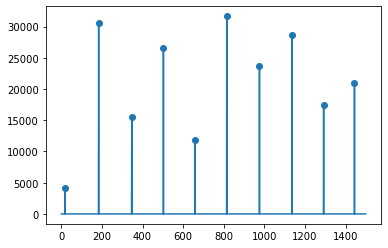

[  18  184  347  503  659  815  976 1136 1292 1444]
[166 163 156 156 156 161 160 156 152]


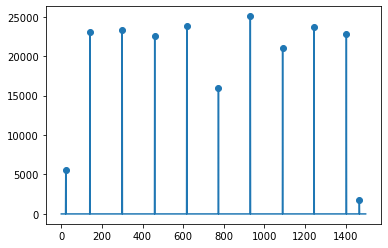

[  22  141  300  460  618  774  931 1090 1245 1404 1468]
[119 159 160 158 156 157 159 155 159  64]


In [75]:
for cnt, pieces in enumerate(all_pieces_energy_32):
    signal = good_signals[cnt]

    realigned_pieces = realigned_all_pieces[cnt]

    template = np.mean(realigned_pieces, axis=0)

    filtered_signal = np.convolve(signal, template[::-1], mode='same')
    squared_filtered_signal = np.square(filtered_signal)
    localmax_filtered_signal = local_max(squared_filtered_signal, window=64)
    peaks_pos, _ = find_peaks(localmax_filtered_signal)
    # peaks_pos, np.diff(peaks_pos)
    plt.plot(localmax_filtered_signal)
    plt.scatter(peaks_pos, localmax_filtered_signal[peaks_pos])
    plt.show()
    print(peaks_pos)
    print(np.diff(peaks_pos))

    if cnt > 30:
        break

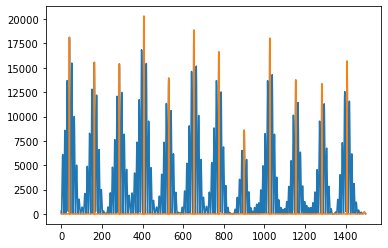

In [49]:


filtered_signal = local_max(squared_filtered_signal)
plt.plot(squared_filtered_signal)
plt.plot(filtered_signal)


In [52]:
peaks_pos, _ = find_peaks(filtered_signal)
peaks_pos, np.diff(peaks_pos)

(array([  40,  163,  286,  407,  529,  653,  776,  901, 1027, 1155, 1283,
        1407, 1493], dtype=int64),
 array([123, 123, 121, 122, 124, 123, 125, 126, 128, 128, 124,  86],
       dtype=int64))